# Import modules

In [43]:
import cv2
import os, os.path
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Conv2D, Dense, Input, Flatten, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, tanh
import matplotlib.pyplot as plt

# Define hyperparameters

In [44]:
# Define hyperparameters

optimizer = Adam(learning_rate=1e-4)
batch_size = 10
epochs = 1000
coef_reg = 0.00001 # Coefficient for L2 regularizer of weights
coef_bias_reg = 0 # Coefficient for L2 regularizer of biases
act = 'relu' # Choice of activation functions (either relu or tanh)

# Define utility functions

In [53]:
def createDataset(img_folder, label_path,scale_percent=70):
# This function create dataset from a folder of images and a label file. 
# scale_percent is how much you want to scale the images down
# The outputs are a numpy array of images and a numpy array of locations of phones
    images = []
    labels = []
    f = open(label_path)
    lines = f.readlines()
    for line in lines:
        if(line.strip() != ""):
            img, x, y = line.split(" ")
            if(os.path.exists(os.path.join(img_folder,img))):
                img_ = cv2.imread(os.path.join(img_folder,img))
                width = int(img_.shape[1] * scale_percent / 100)
                height = int(img_.shape[0] * scale_percent / 100)
                dim = (width, height)
                images.append(cv2.resize(img_, dim, interpolation = cv2.INTER_AREA))
                labels.append([float(x),float(y)])
    return np.asarray(images).astype("float32"), np.asarray(labels).astype("float32") #tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

def getAccuracy(model, x, y):
# This function computes the accuracy of a model with respect to input x and the ground-truth label y
  y_pred = model.predict(x)
  diff = np.abs(y_pred - y)
  correct = 0
  for pair in diff:
    if(np.sqrt(pair[0]**2 + pair[1]**2) <= 0.05):
      correct += 1
  return correct / len(y)

# Buiild and preprocess dataset

In [46]:
x, y = createDataset("find_phone_data", "find_phone_data/labels.txt") # Build a training dataset
x = x/255  # Normalize the dataset
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2, shuffle=True) # Split the dataset into training and validation

# Build a machine learning model based on VGG-16

In [47]:
# Build a machine learning model for phone detection based on VGG-16

input = Input((x.shape[1], x.shape[2], x.shape[3]))
# 1st Conv Block

conv1 = Conv2D (filters =64, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(input)
conv2 = Conv2D (filters =64, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv1)
max1 = MaxPool2D(pool_size =2, strides =2, padding ='same')(conv2)
# 2nd Conv Block

conv3 = Conv2D (filters =128, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(max1)
conv4 = Conv2D (filters =128, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv3)
max2 = MaxPool2D(pool_size =2, strides =2, padding ='same')(conv4)

# 3rd Conv block

conv5 = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(max2)
conv6 = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv5)
conv7 = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv6)
max3 = MaxPool2D(pool_size =2, strides =2, padding ='same')(conv7)
# 4th Conv block

conv8 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(max3)
conv9 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv8)
conv10 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv9)
max4 = MaxPool2D(pool_size =2, strides =2, padding ='same')(conv10)

# 5th Conv block

conv11 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(max4)
conv12 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv11)
conv13 = Conv2D (filters =512, kernel_size =3, padding ='same', kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv12)
batch2 = BatchNormalization()(conv13)
if(act == 'relu'):
  act1 = relu(batch2)
elif(act == 'tanh'):
  act1 = tanh(batch2)
max5 = MaxPool2D(pool_size =2, strides =2, padding ='same')(act1)

# Fully connected layers

flat = Flatten()(max5)
dense1 = Dense(units = 4096, activation =act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(flat)
drop1 = Dropout(0.8)(dense1)
dense2 = Dense(units = 512, activation =act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(drop1)
output = Dense(units = 2, activation ='sigmoid', kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(dense2)

# Creating the model

model = Model (inputs=input, outputs =output)
model.compile(optimizer=optimizer, loss=tf.losses.MeanSquaredError(),metrics=['mae', 'mse'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 228, 343, 3)]     0         
                                                                 
 conv2d_65 (Conv2D)          (None, 228, 343, 64)      1792      
                                                                 
 conv2d_66 (Conv2D)          (None, 228, 343, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 114, 172, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 114, 172, 128)     73856     
                                                                 
 conv2d_68 (Conv2D)          (None, 114, 172, 128)     147584    
                                                           

# Train the model

In [48]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001) # Reduce the learning rate when it is plateau
earlystop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # Early stop the training when there is no improvement
hist = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val), callbacks=[earlystop, reduce_lr])

Epoch 1/1000
11/11 [==============================] - 8s 492ms/step - loss: 0.1817 - mae: 0.2105 - mse: 0.0593 - val_loss: 0.1773 - val_mae: 0.2121 - val_mse: 0.0557 - lr: 1.0000e-04
Epoch 2/1000
11/11 [==============================] - 4s 387ms/step - loss: 0.1753 - mae: 0.2036 - mse: 0.0545 - val_loss: 0.1754 - val_mae: 0.2122 - val_mse: 0.0558 - lr: 1.0000e-04
Epoch 3/1000
11/11 [==============================] - 4s 390ms/step - loss: 0.1726 - mae: 0.2009 - mse: 0.0540 - val_loss: 0.1730 - val_mae: 0.2123 - val_mse: 0.0558 - lr: 1.0000e-04
Epoch 4/1000
11/11 [==============================] - 4s 390ms/step - loss: 0.1703 - mae: 0.2005 - mse: 0.0541 - val_loss: 0.1704 - val_mae: 0.2122 - val_mse: 0.0557 - lr: 1.0000e-04
Epoch 5/1000
11/11 [==============================] - 4s 393ms/step - loss: 0.1625 - mae: 0.1862 - mse: 0.0488 - val_loss: 0.1674 - val_mae: 0.2110 - val_mse: 0.0552 - lr: 1.0000e-04
Epoch 6/1000
11/11 [==============================] - 4s 394ms/step - loss: 0.1420 - 

In [49]:
model.save("phone_detection.h5")

# Plot information during training

Text(0.5, 1.0, 'Loss (MSE + L2 Regularization)')

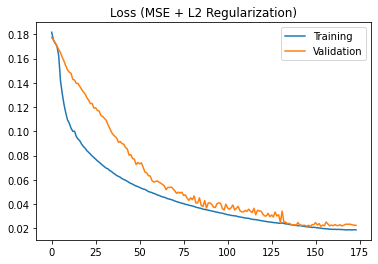

In [50]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(["Training", "Validation"])
plt.title("Loss (MSE + L2 Regularization)")
plt.savefig('figures/loss.png', dpi=450, bbox_inches='tight')

Text(0.5, 1.0, 'MAE')

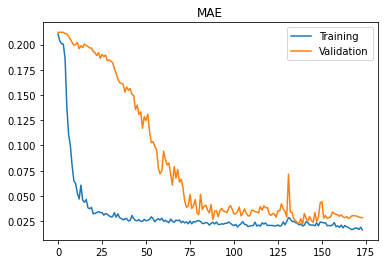

In [51]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.legend(["Training", "Validation"])
plt.title("MAE")
plt.savefig('figures/mae.png', dpi=450, bbox_inches='tight')

In [54]:
training_acc = getAccuracy(model, x_train, y_train)
val_acc = getAccuracy(model, x_val, y_val)
print(f"Training accuracy: {training_acc}\nVal accuracy: {val_acc}")

Training accuracy: 1.0
Val accuracy: 0.7692307692307693
